In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
import calendar

As always, i import:
* pandas for data manipulation
* matplotlib for visualization 
* fuzzywuzzy for string matching in data
*  calendar for converting month number to month name.

In [2]:
df = pd.read_excel("../data/full vacancy data.xlsx")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1668 entries, 0 to 1667
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          1668 non-null   int64 
 1   Id                  1668 non-null   int64 
 2   Name                1668 non-null   object
 3   Url to Vacancy      1668 non-null   object
 4   Company             1668 non-null   object
 5   Location            1084 non-null   object
 6   Type of Employment  1668 non-null   object
 7   Age category        77 non-null     object
 8   Education degree    698 non-null    object
 9   Salary              1668 non-null   object
 10  Posting Date        1661 non-null   object
 11  Deadline Date       1661 non-null   object
 12  Skills              1654 non-null   object
 13  Vacancy Alter Name  1513 non-null   object
dtypes: int64(2), object(12)
memory usage: 182.6+ KB


 
- In `full vacancy data` file contains all data, such as vacancy name, ID, URL, company, location, etc from February 2015 to 2024 March .


## Columns in vacancy primary info
* Location - Where is job located 
* Age category - Age requirement
* Posting Date - When vacancy was posted
* Deadline Date - When vacancy will cease to be relevant
* Skills = Skills that needed in vacancy

Display the number of non-null rows in the DataFrame.
As we can see, only 77 out of 1668 vacancies have an age category, and 698 require some education degree.

In [3]:
df.head()

,Unnamed: 0,Id,Name,Url to Vacancy,Company,Location,Type of Employment,Age category,Education degree,Salary,Posting Date,Deadline Date,Skills,Vacancy Alter Name
0,0,1,QA Intern – Functional Testing,https://busy.az/vacancy/122893/qa-intern-funct...,a1qa,Bakı,Tam ştat (full time),25 - 45,Ali,Razılaşma yolu ilə,19.03.2024,19.04.2024,"[JavaScript, Figma, software development, prog...","[proqramçı, programmer, software developer, pr..."
1,1,2,React Native Developer,https://busy.az/vacancy/122877/react-native-de...,Air Group,Bakı,Tam ştat (full time),NaN,NaN,Razılaşma yolu ilə,19.03.2024,03.04.2024,"[software development, programming, proqramlaş...","[mobile application developer, mobile develope..."
2,2,3,IOS developer,https://busy.az/vacancy/122830/ios-developer,Bank Respublika ASC,Bakı,Tam ştat (full time),NaN,NaN,Razılaşma yolu ilə,19.03.2024,19.04.2024,"[software development, programming, proqramlaş...","[mobile application developer, mobile develope..."
3,3,4,iOS Developer (Swift UI),https://busy.az/vacancy/122828/ios-developer-s...,Bank Respublika ASC,Bakı,Tam ştat (full time),NaN,Ali (bakalavr),Razılaşma yolu ilə,18.03.2024,18.04.2024,"[Oracle, PL/SQL, Oracle SQL, programming, proq...","[PL/SQL developer, proqramçı, programmer, soft..."
4,4,5,Baş PL/SQL Developer,https://busy.az/vacancy/122680/bas-plsql-devel...,Ziraat Bank Azərbaycan,Bakı,Tam ştat (full time),NaN,NaN,Razılaşma yolu ilə,16.03.2024,16.04.2024,"[Russian language, rus dili, English language,...","[Java developer, proqramçı, programmer, softwa..."


Display the first five rows of data from `full vacancy data` to get an idea of what data is stored in the columns.
`Skills` and `Vacancy Alter Name` are array. This format is convenient to read, but inconvenient to work in Pandas, as it does not allow you to collect information about each individual skill. 
Let's change `Skills` and `Vacancy Alter Name` format

In [4]:
df_copy = df.copy()
df_copy[['Skills', 'Vacancy Alter Name']] = df_copy[['Skills', 'Vacancy Alter Name']].astype(str)

skills_df = df_copy['Skills'].str.strip('[]').str.split(',').explode().reset_index(drop=True)
alter_name_df = df_copy['Vacancy Alter Name'].str.strip('[]').str.split(',').explode().reset_index(drop=True)

id_list = []
name_list = []
company_list = []
for idx, row in df_copy.iterrows():
    skills = row['Skills'].split(',')
    id_list.extend([row['Id']] * len(skills))
    name_list.extend([row['Name']] * len(skills))
    company_list.extend([row['Company']] * len(skills))

id_df = pd.DataFrame({'Id': id_list, 'Name': name_list,'Company': company_list})
separated_skills = pd.concat([id_df, skills_df, alter_name_df], axis=1)
separated_skills

,Id,Name,Company,Skills,Vacancy Alter Name
0,1,QA Intern – Functional Testing,a1qa,JavaScript,proqramçı
1,1,QA Intern – Functional Testing,a1qa,Figma,programmer
2,1,QA Intern – Functional Testing,a1qa,software development,software developer
3,1,QA Intern – Functional Testing,a1qa,programming,proqram təminatçısı
4,2,React Native Developer,Air Group,software development,mobile application developer
...,...,...,...,...,...
9689,1668,Software Developer,CRM Group,web developer,NaN
9690,1668,Software Developer,CRM Group,программист,NaN
9691,1668,Software Developer,CRM Group,proqramçı,NaN
9692,1668,Software Developer,CRM Group,programmer,NaN


Now we can see every Skill and Alter Name as row

In [5]:
def similar_strings(data_frame, column):
    unique_strings = data_frame[column].unique() 
    
    for string1 in unique_strings:
        for string2 in unique_strings:
            if string1 != string2 and fuzz.ratio(string1, string2) > 90: 
                data_frame[column] = data_frame[column].replace({string2: string1})  
    return data_frame

    """
    Function to similar strings in a DataFrame column.

    Parameters:
    - data_frame: DataFrame containing the data.
    - column: Name of the column with strings to be merged.

    Returns:
    - DataFrame with similar strings merged.
    """

In [6]:
def matplotlib_graphic(data_frame,column_name,limit = 0):
    data_frame[column_name] = data_frame[column_name].astype(str)
    df_with_filter = similar_strings(data_frame, column_name)
    
    if limit == 0: 
        counts =  df_with_filter[column_name].where(df_with_filter[column_name] != "nan").dropna().value_counts()
    else:
        counts =  df_with_filter[column_name].where(df_with_filter[column_name] != "nan").dropna().value_counts()[:limit]
    return counts

    """
    Function for visualization of the frequency of unique values in a DataFrame column.

    Parameters:
    - data_frame: DataFrame containing the data.
    - column_name: Name of the column for visualization.
    - limit: Maximum number of unique values to consider. Default is 0 (all unique values).

    Returns:
    - Series with the frequency counts of unique values in the specified column.
    """

In [7]:
drop_same_data = similar_strings(df, 'Name')
drop_same_data.dropna().describe(include='all').transpose().loc[:, 'top']

Unnamed: 0                                                          NaN
Id                                                                  NaN
Name                          Proqramlaşdırma şöbəsinin baş mütəxəssisi
Url to Vacancy        https://busy.az/vacancy/122893/qa-intern-funct...
Company                                                 TuranBank   ASC
Location                                                           Bakı
Type of Employment                                 Tam ştat (full time)
Age category                                                   25  - 45
Education degree                                                    Ali
Salary                                               Razılaşma yolu ilə
Posting Date                                                 14.11.2021
Deadline Date                                                14.12.2021
Skills                [software development, proqramlaşdırma, proqra...
Vacancy Alter Name    [программист, proqramçı, software develope

## Let's find out the most common values in each column

* Every Id is unique, so there cannot be a common value.
* The most popular title name is `Front End Developer`
* The company with the most vacancies is `Kapital Bank`
* The age category is between 25 and 45. In that age, most specialists are already in middle-senior positions.
* The type of employment is `Tam ştat (full time)`.
* The education degree is `Ali` (Bachelor's degree). Most employers want employees with higher education.
* Salary information is mostly not provided.
* Skills is the array with abstract skills(like software development or программирование)
* Vacancy Alter Name is generalized names of the profession

In [8]:
separated_skills.describe(include='all').transpose().loc[:, 'top']

Id                                    NaN
Name                    Android Developer
Company                      Kapital Bank
Skills                        programming
Vacancy Alter Name     software developer
Name: top, dtype: object

 The most common skill is `programming` which is logical. However, we want to see the most popular skill excluding terms like `software development` or `programming`.
 So, I created an array with these common skills.

In [9]:
tags_to_remove = ["software development","software developer",
                  "proqramlaşdırma", "programming","proqramçı",
                  "программирование","proqram təminatı","programmer", "программист"]

skills = separated_skills['Skills'].str.strip()
skills = skills[~skills.isin(tags_to_remove)]
skills.mode().iloc[0]

'SQL'

The most common skill in job postings is `SQL`, which is not surprising since Back-end, FullStack, and sometimes even Front-end roles require knowledge of SQL for portfolio projects.

In [10]:
df[['Posting Date', 'Deadline Date']] = df[['Posting Date', 'Deadline Date']].apply(pd.to_datetime, dayfirst=True)
df

,Unnamed: 0,Id,Name,Url to Vacancy,Company,Location,Type of Employment,Age category,Education degree,Salary,Posting Date,Deadline Date,Skills,Vacancy Alter Name
0,0,1,QA Intern – Functional Testing,https://busy.az/vacancy/122893/qa-intern-funct...,a1qa,Bakı,Tam ştat (full time),25 - 45,Ali,Razılaşma yolu ilə,2024-03-19,2024-04-19,"[JavaScript, Figma, software development, prog...","[proqramçı, programmer, software developer, pr..."
1,1,2,React Native Developer,https://busy.az/vacancy/122877/react-native-de...,Air Group,Bakı,Tam ştat (full time),NaN,NaN,Razılaşma yolu ilə,2024-03-19,2024-04-03,"[software development, programming, proqramlaş...","[mobile application developer, mobile develope..."
2,2,3,İOS developer,https://busy.az/vacancy/122830/ios-developer,Bank Respublika ASC,Bakı,Tam ştat (full time),NaN,NaN,Razılaşma yolu ilə,2024-03-19,2024-04-19,"[software development, programming, proqramlaş...","[mobile application developer, mobile develope..."
3,3,4,iOS Developer (Swift UI),https://busy.az/vacancy/122828/ios-developer-s...,Bank Respublika ASC,Bakı,Tam ştat (full time),NaN,Ali (bakalavr),Razılaşma yolu ilə,2024-03-18,2024-04-18,"[Oracle, PL/SQL, Oracle SQL, programming, proq...","[PL/SQL developer, proqramçı, programmer, soft..."
4,4,5,Baş PL/SQL Developer,https://busy.az/vacancy/122680/bas-plsql-devel...,Ziraat Bank Azərbaycan,Bakı,Tam ştat (full time),NaN,NaN,Razılaşma yolu ilə,2024-03-16,2024-04-16,"[Russian language, rus dili, English language,...","[Java developer, proqramçı, programmer, softwa..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1663,1663,1664,Java Developer,https://busy.az/vacancy/19218/java-developer,Unibank,NaN,Tam ştat (full time),NaN,NaN,Razılaşma yolu ilə,2015-04-06,2015-05-06,"[Java developer, программист, proqramçı, progr...",NaN
1664,1664,1665,Software developer (Java),https://busy.az/vacancy/18384/software-develop...,CyberNet,NaN,Tam ştat (full time),NaN,NaN,Razılaşma yolu ilə,2015-04-06,2015-05-06,"[Java developer, программист, proqramçı, progr...",NaN
1665,1665,1666,Software developer (Java),https://busy.az/vacancy/18384/software-develop...,CyberNet,NaN,Tam ştat (full time),NaN,NaN,Razılaşma yolu ilə,2015-04-01,2015-05-01,"[программист, proqramçı, programmer, software ...",NaN
1666,1666,1667,Software developer,https://busy.az/vacancy/18340/software-developer,Novamedia MMC,NaN,Tam ştat (full time),NaN,NaN,Razılaşma yolu ilə,2015-03-17,2015-04-16,"[программист, proqramçı, programmer, software ...",NaN


Change the type of two columns from `object` to `date` for further work in the future

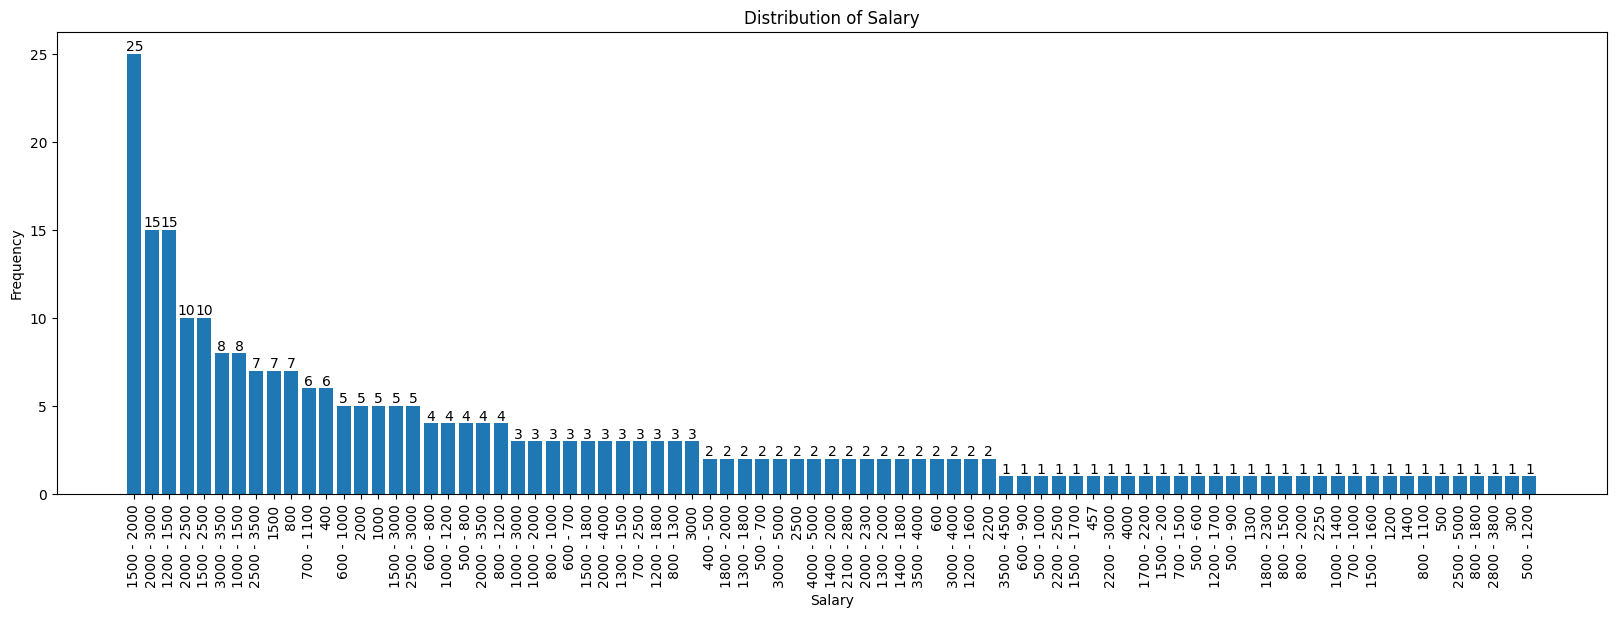

In [11]:
salary_counts =  df['Salary'].where(df['Salary'] != 'Razılaşma yolu ilə').value_counts()

plt.figure(figsize=(20,6))
plt.bar(salary_counts.index, salary_counts.values)
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.title('Distribution of Salary')
plt.xticks(rotation=90)

for i, count in enumerate(salary_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.show()

The first visualization is salary, perhaps the most important aspect of a job. I removed all entries with "Razılaşma yolu ilə" and kept only numerical values.

* In the first place, we see `1500-2000₼`, which represents a salary for new middle-level employees.
* The second most common range is `2000-3000₼`, indicating a strong middle to new senior level.
* Third place is `1200-1500₼`, which I assume is for strong junior positions.
* Fourth place is `2000-2500₼`, representing a strong middle-level salary.
* The fifth most common range is `3000-3500₼`, indicating senior-level positions.
* The minimum salary observed is `300₼`, while the maximum is in the `4000-5000₼` range.

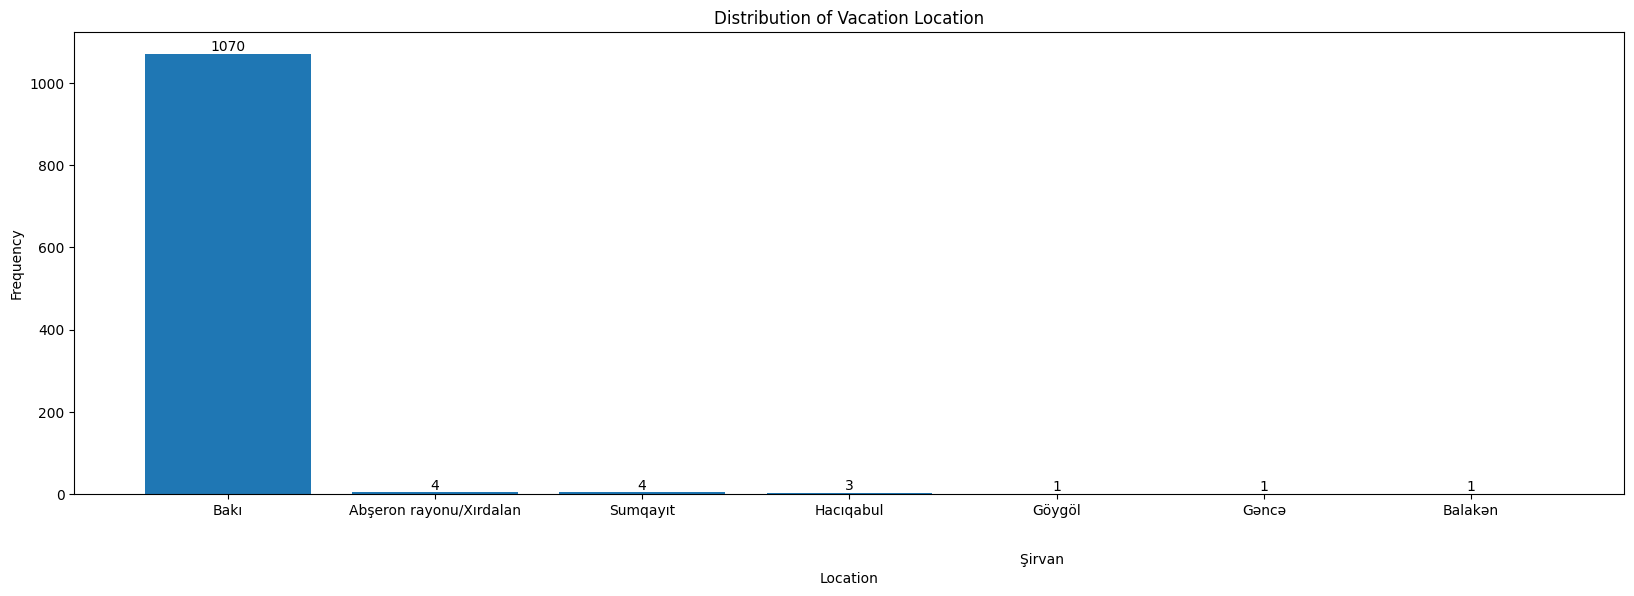

In [12]:
location_counts = matplotlib_graphic(df,'Location')

plt.figure(figsize=(20,6))
plt.bar(location_counts.index, location_counts.values)
plt.xlabel('Location')
plt.ylabel('Frequency')
plt.title('Distribution of Vacation Location')

for i, count in enumerate(location_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')
    
plt.show()

 Job location is predominantly `Baki`, the capital and largest city of Azerbaijan.
 Only 16 out of 1086 vacancies are located outside Baki.

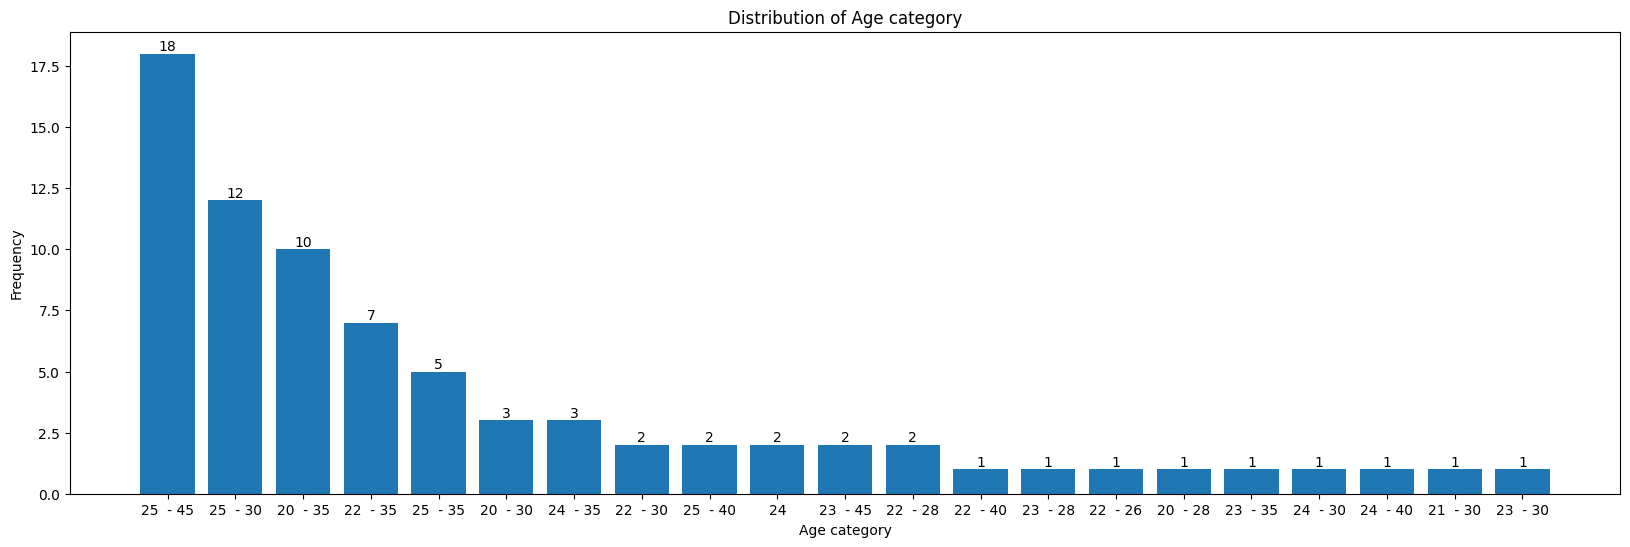

In [13]:
age_category_count =  df['Age category'].dropna().value_counts()

plt.figure(figsize=(20,6))
plt.bar(age_category_count.index, age_category_count.values)
plt.xlabel('Age category')
plt.ylabel('Frequency')
plt.title('Distribution of Age category')

for i, count in enumerate(age_category_count.values):
    plt.text(i, count, str(count), ha='center', va='bottom')
    
plt.show()

# The next statistics visualization is age category.
* The most common age category is `25-45`, which is ideal for young employees with experience. 
* The second most common is `25-35`, indicating a high proportion of juniors within this age range.
* The third is `20-35`, which is slightly younger than the second.
* The most popular age range is between `20-25`.
* The least in demand age category is `50` and above.

There is limited data because many employers do not specify age requirements.

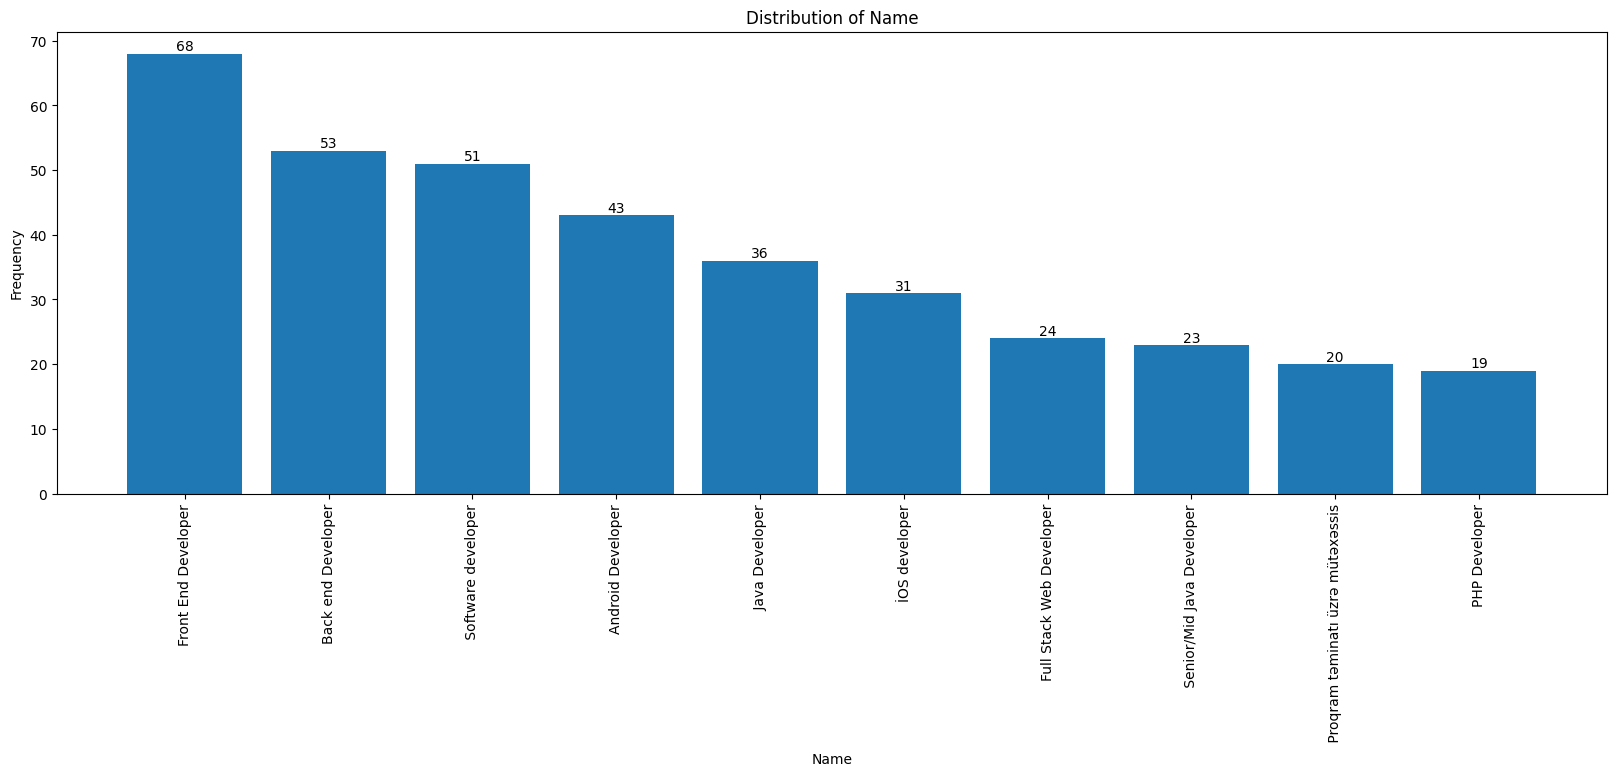

In [14]:
vacancy_name_count = matplotlib_graphic(df,'Name',10)

plt.figure(figsize=(20,6))
plt.bar(vacancy_name_count.index, vacancy_name_count.values)
plt.xlabel('Name')
plt.ylabel('Frequency')
plt.title('Distribution of Name')
plt.xticks(rotation= 90 ,fontsize=10)

for i, count in enumerate(vacancy_name_count.values):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.show()

Name(Title) statistics
Top 3 titles are generalized, making it difficult to discern specific programming requirements.
* First place - Front-end developer
* Second place - Back-end developer
* Third place - Software developer
* Fourth place - Android developer,In high demand due to the widespread use of the Android operating system, found on a variety of devices such as smartphones, tablets, and smart TVs. 
* In fourth place, we see `Java Developer`, indicating a more specific requirement.
* In fifth place, we have the generalized title `iOS developer`. iOS is the second most popular mobile operating system, hence the demand for iOS development skills.
* In the sixth place, we have `FullStack`.  Skilled in both front-end and back-end development, capable of handling all aspects of web development.
* In the seventh place, we have `Senior Java Developer` Highly experienced Java programmer with advanced skills and expertise.
In general, we can observe that `Java` is the most popular language in vacancy titles.


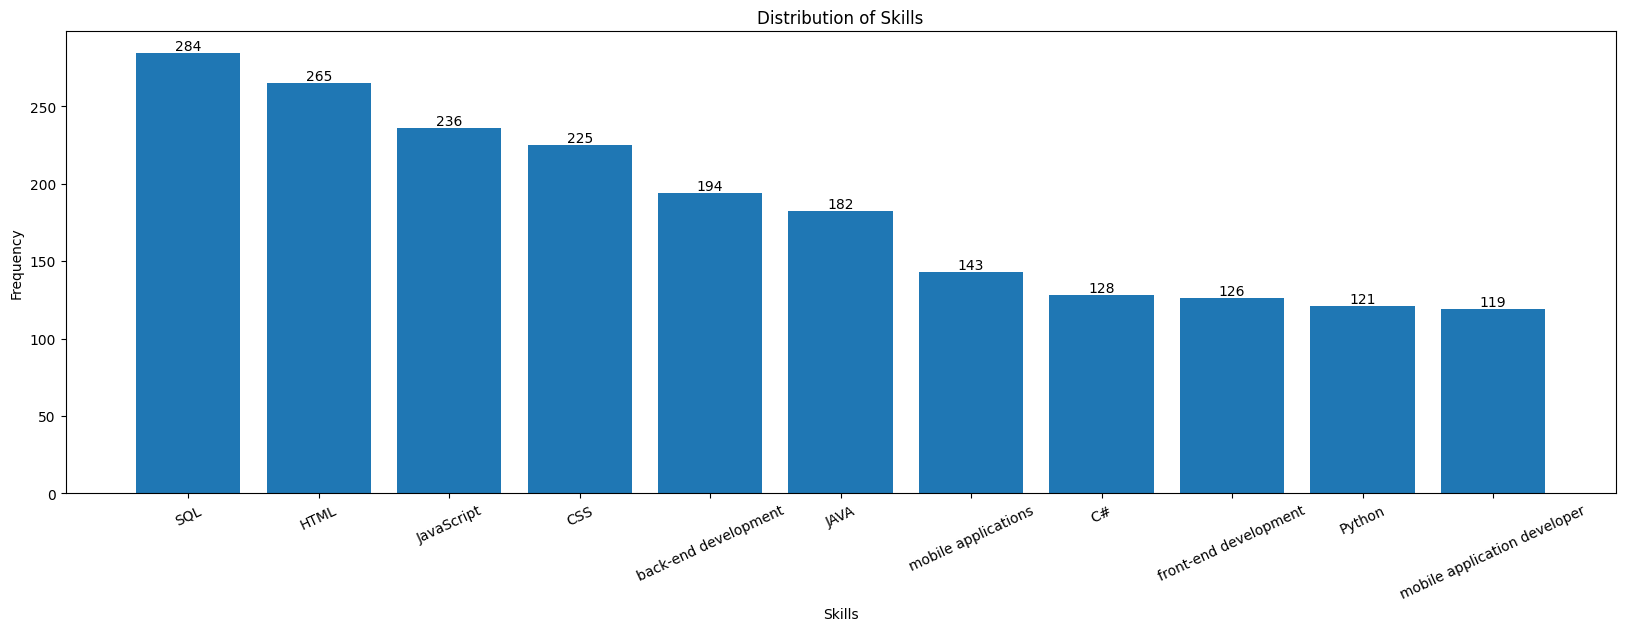

In [15]:
separated_skills['Skills'] = separated_skills['Skills'].str.strip()

tags_count = matplotlib_graphic(separated_skills, 'Skills', 20)
tags_count = tags_count[~tags_count.index.isin(tags_to_remove)]

plt.figure(figsize=(20, 6))
plt.bar(tags_count.index, tags_count.values)
plt.xlabel('Skills')
plt.ylabel('Frequency')
plt.title('Distribution of Skills')
plt.xticks(rotation=25, fontsize=10)

for i, count in enumerate(tags_count.values):
    plt.text(i, count, str(count), ha='center', va='bottom')
    
plt.show()

## The most important data for me is skills.
* We already know the most popular skill - `SQL`.
* Second place is `HTML`. All front-end and full-stack developers must know HTML .
* `JavaScript` is the most popular programming language due to its versatility, being used for both back-end and front-end development.
* `CSS` is a markup language essential for styling websites.
* `Back-end development` is a general skill, indicating proficiency in at least one back-end programming language (`Python`, `C#`, `Java`, etc.), SQL or NoSQL databases, and more.
* `Java` is the most popular back-end language due to its cross-platform compatibility.
* `Mobile applications` and `mobile application develiper` is another general skill required in various development roles.
* `C#` is a back-end programming language similar to `Java`, forming a part of the `.NET` framework with its own libraries.
* `Python` is the language used to write these codes, known for its flexibility and extensive libraries.


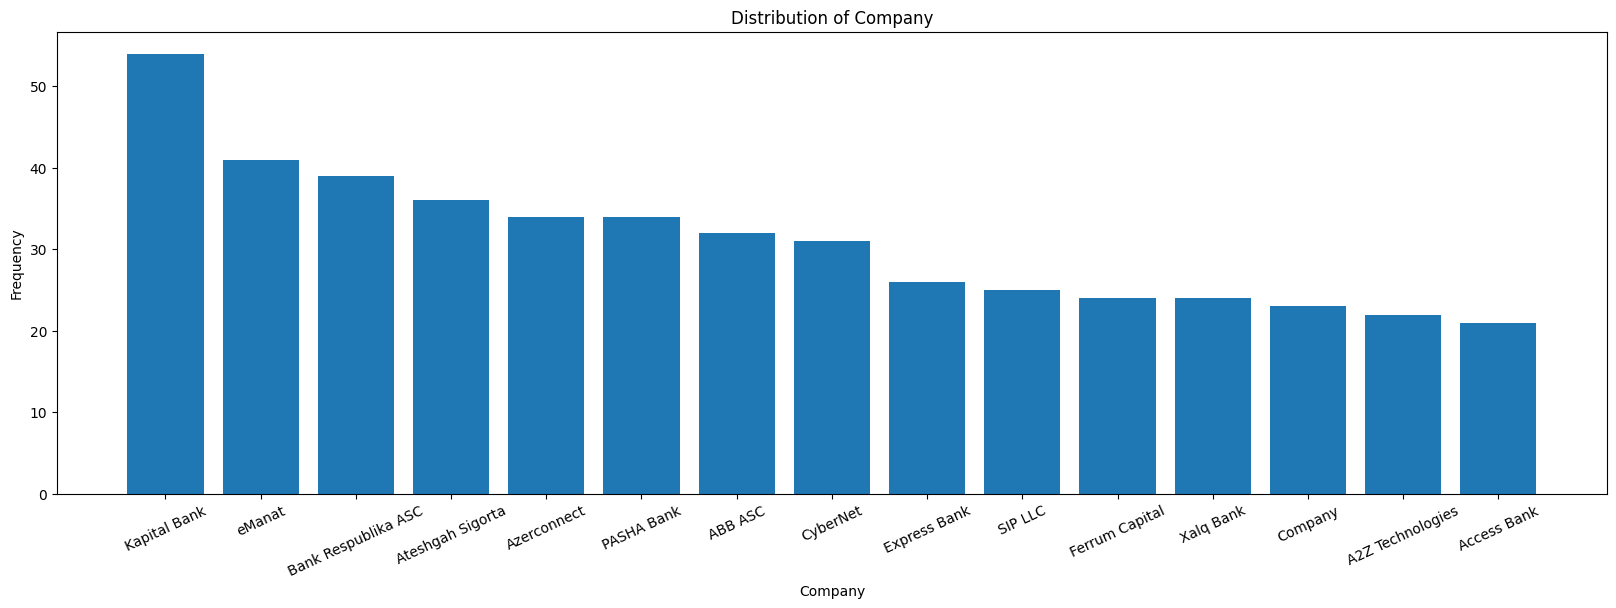

In [16]:
company_count = matplotlib_graphic(df, 'Company',15)

plt.figure(figsize=(20, 6))
plt.bar(company_count.index, company_count.values)
plt.xlabel('Company')
plt.ylabel('Frequency')
plt.title('Distribution of Company')
plt.xticks(rotation=25, fontsize=10)
    
plt.show()

In [17]:
df_without_repeat = separated_skills[~separated_skills['Skills'].str.strip().isin(tags_to_remove)]
df_without_repeat = df_without_repeat.dropna().where(df_without_repeat!="nan")

grouped_data = df_without_repeat.groupby(['Name', 'Skills']).size().reset_index(name='Tag Count').apply(list)
grouped_data_sorted = grouped_data.sort_values(by='Tag Count', ascending=False)[:15]

grouped_data_sorted

,Name,Skills,Tag Count
61,Android Developer,HTML,6
67,Android Developer,JavaScript,6
75,Android Developer,SQL,6
384,Backend Developer,JavaScript,6
604,DevOps Engineer,HTML,6
59,Android Developer,CSS,5
379,Backend Developer,HTML,5
998,Frontend developer,SQL,4
89,Android Developer,mobile applications,4
602,DevOps Engineer,CSS,4


Unfortunately, I cannot visualize this table as a plot, but I believe it provides a clearer understanding.
`HTML` remains on the top as usual. Even DevOps engineers require knowledge of HTML.
(Note: DevOps engineers need to understand HTML to effectively manage web infrastructure and collaborate with developers and other team members.)


In [18]:
the_25_most_popular_tags_by_company = (df_without_repeat
                                       .groupby(['Company', 'Skills'])
                                       .size()
                                       .reset_index(name='Skills Count')
                                       .sort_values(by='Skills Count', ascending=[False])
                                       .groupby('Company')
                                       .head(1))[:25]

the_25_most_popular_tags_by_company

,Company,Skills,Skills Count
2593,eManat,HTML,12
1420,Kapital Bank,SQL,10
335,Ateshgah Sigorta,SQL,8
1825,PASHA Bank,HTML,7
589,Bank Respublika ASC,CSS,7
2668,İnformasiya Texnologiyaları və Məlumat İdarəet...,HTML,7
66,A2Z Technologies,mobile applications,7
431,Azerconnect,JavaScript,6
81,ABB ASC,HTML,6
2451,Xalq Bank,HTML,6


1. Most in-demand skills by companies: Describe which specific skills are most frequently required by different companies. For example:
    * `eManat`, `PASHA Bank` and `Kapital Bank` often require expertise in HTML and CSS, indicating a need for web developers or designers.
    * `A2Z Technologies` focus on mobile application skills, suggesting their interest in mobile app development.
2. Trends in required skills: Highlight recurring skills and draw conclusions about which technologies or development areas are most sought after. For instance:
    * `HTML` and `CSS` are consistently sought after by various banks, indicating the importance of front-end web development skills in the financial sector.
    *  Focus on `JavaScript` `HTML`, `CSS` and `SQL` skills reflects the growing demand for web applications

Text(0.5, 1.0, 'Top 25 Posting Vacancy Count')

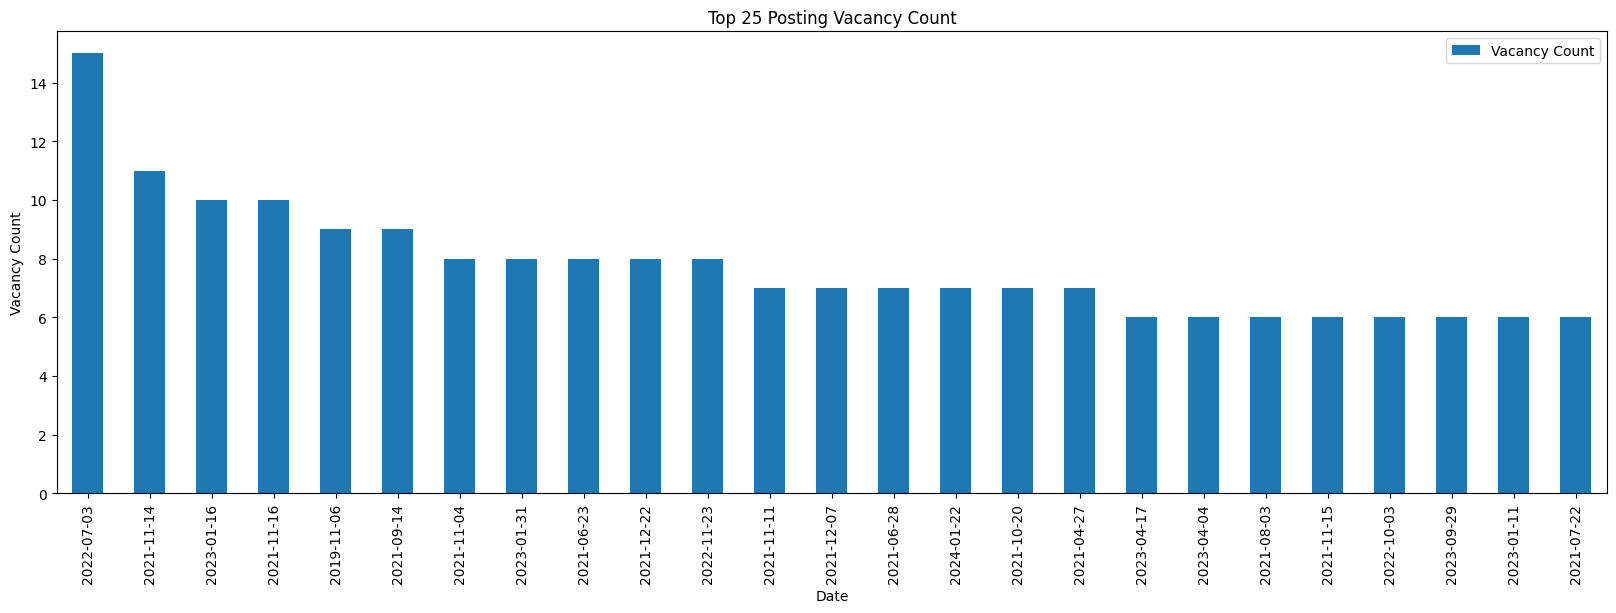

In [19]:
df_sorted_by_post_date = (df.groupby(['Posting Date'])
                                .size()
                                .reset_index(name='Vacancy Count')
                                .sort_values(by='Vacancy Count', ascending=[False]))[:25]

df_sorted_by_post_date['Short Date'] = pd.DataFrame(df_sorted_by_post_date)['Posting Date'].dt.strftime('%Y-%m-%d')

df_sorted_by_post_date.plot(kind="bar", x="Short Date", y="Vacancy Count", figsize=(20,6))
plt.xlabel("Date")
plt.ylabel("Vacancy Count")
plt.title("Top 25 Posting Vacancy Count")

<Axes: xlabel='Month'>

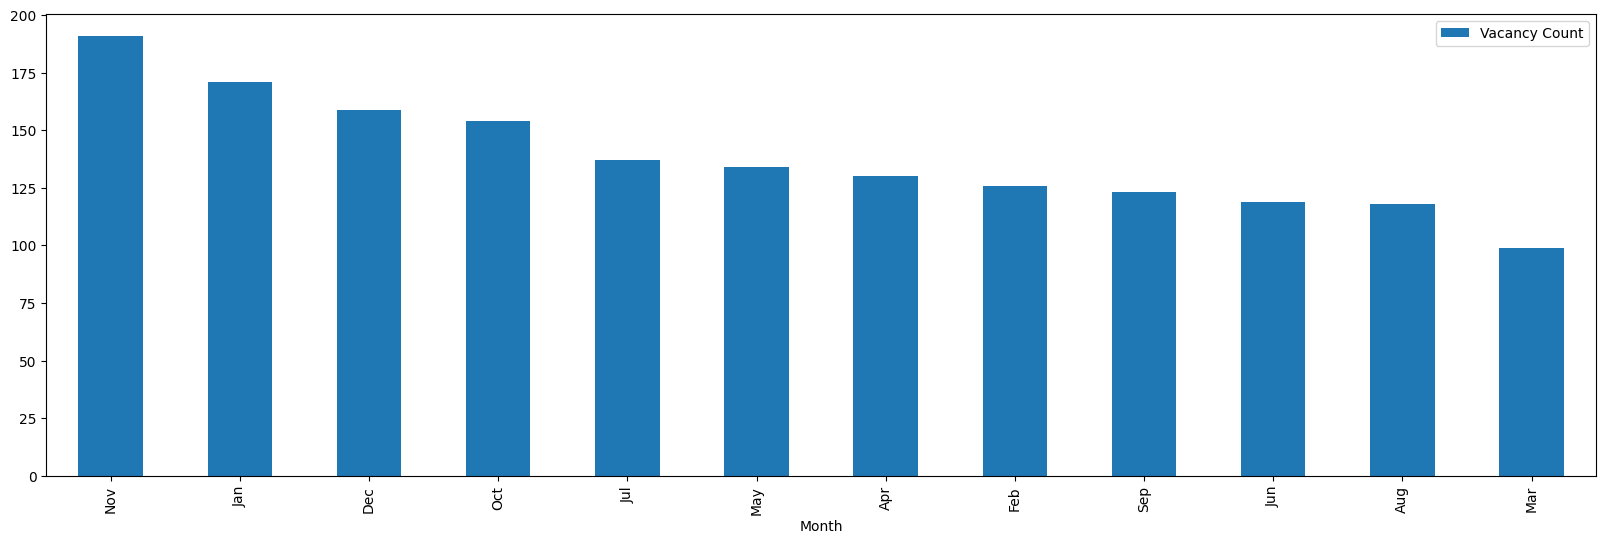

In [20]:
df["Posting Date"] = pd.to_datetime(df["Posting Date"], dayfirst=True)
df["Month"] = df["Posting Date"].dt.strftime('%m')

df_sorted_by_time = (df
                     .groupby(['Month'])
                     .size()
                     .reset_index(name='Vacancy Count')
                     .sort_values(by='Vacancy Count', ascending=False))

df_sorted_by_time["Month"] = df_sorted_by_time["Month"].apply(lambda x: calendar.month_abbr[int(x)])
df_sorted_by_time.plot(kind="bar", x="Month", y="Vacancy Count", figsize=(20, 6))

# New vacancies count by month

The highest number of new vacancies is observed in November. Possible reasons for this surge include:
* End-of-Year Deadlines: Employers may need additional staff to meet end-of-year project deadlines, prompting them to hire more aggressively.
* Vacation Timing: Many employees take their vacation days earlier in the year, leaving vacancies to be filled by November.
* Strategic Hiring: Companies strategically hire to accelerate project completion and achieve year-end goals.
* Increased productivity: Some companies may be looking to complete new hires by the end of the year so they can start the next year with a staff fully staffed and ready to go.